In [16]:
import sys
import pandas as pd
from scipy.stats import spearmanr,kendalltau
import numpy as np
from sklearn.utils import resample
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("xgboost_result.csv")

In [24]:
def bootstrap_pairs(truth_1, pred_1, truth_2, pred_2, method, alpha=0.95, sample_frac=0.5, iterations=10000):
    assert(len(truth_1) == len(truth_2))
    assert(len(pred_1) == len(pred_2))
    val_1 = method(truth_1, pred_1)[0]
    val_2 = method(truth_2, pred_2)[0]
    pred_cor = method(pred_1, pred_2)[0]
    delta = val_1 - val_2
    index_list = range(0, len(truth_1))
    num_samples = int(len(index_list) * sample_frac)
    stats = []
    for _ in range(0, iterations):
        sample_idx = resample(index_list, n_samples=num_samples)
        pred_1_sample = [pred_1[x] for x in sample_idx]
        pred_2_sample = [pred_2[x] for x in sample_idx]
        truth_1_sample = [truth_1[x] for x in sample_idx]
        truth_2_sample = [truth_2[x] for x in sample_idx]
        s1 = method(pred_1_sample, truth_1_sample)[0]
        s2 = method(pred_2_sample, truth_2_sample)[0]
        stats.append(s1 - s2)
    p = ((1.0 - alpha) / 2.0) * 100
    lower = max(-1.0, np.percentile(stats, p))
    p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    return [lower, delta, upper, pred_cor]

def evaluate_deltas(df, label_1, label_2, stat_method, bootstrap_iterations=1000):
    gb = df.groupby(["Dataset", "CV_Cycle"])
    bs_delta_list = []
    for k, v in tqdm(gb):
        dataset, cv_cycle = k
        truth_1 = v.query(f"Method == '{label_1}'").Truth.values
        pred_1 = v.query(f"Method == '{label_1}'").Pred.values
        truth_2 = v.query(f"Method == '{label_2}'").Truth.values
        pred_2 = v.query(f"Method == '{label_2}'").Pred.values
        bs_pair_res = bootstrap_pairs(truth_1, pred_1, truth_2, pred_2, stat_method, iterations=bootstrap_iterations)
        bs_delta_list.append([dataset, cv_cycle] + bs_pair_res)
    pair_res_df = pd.DataFrame(bs_delta_list, columns=["DataSet", "Cycle", "Min", "Val", "Max", "Corr"])
    sum_gb = pair_res_df.groupby(["DataSet"])
    output_list = []
    for k, v in sum_gb:
        output_list.append([k, v.Min.mean(), v.Val.mean(), v.Max.mean(), v.Corr.mean()])
    output_df = pd.DataFrame(output_list,columns=["Target","Min","Delta","Max","Corr"])
    return output_df

In [22]:
delta_df = evaluate_deltas(df,'cddd','desc',spearmanr)

100%|██████████| 240/240 [38:35<00:00,  1.30s/it]   

A2a -0.27 -0.04 0.21 0.76
ABL1 -0.12 -0.04 0.04 0.85
Acetylcholinesterase -0.06 -0.03 0.00 0.89
Aurora-A -0.07 -0.03 0.00 0.89
B-raf -0.07 -0.04 0.00 0.89
COX-1 -0.13 -0.04 0.04 0.77
COX-2 -0.06 -0.02 0.01 0.87
Cannabinoid -0.08 -0.03 0.01 0.91
Carbonic -0.06 -0.01 0.04 0.92
Caspase -0.05 -0.02 0.02 0.90
Coagulation -0.08 -0.02 0.03 0.86
Dihydrofolate -0.19 -0.07 0.05 0.80
Dopamine -0.16 -0.05 0.06 0.84
Ephrin -0.06 -0.01 0.04 0.87
Estrogen -0.06 -0.03 -0.00 0.94
Glucocorticoid -0.06 -0.01 0.04 0.89
Glycogen -0.10 -0.04 0.01 0.85
HERG -0.07 -0.03 0.00 0.80
JAK2 -0.09 -0.05 -0.01 0.87
LCK -0.11 -0.05 0.01 0.87
Monoamine -0.11 -0.03 0.04 0.78
Vanilloid -0.07 -0.02 0.03 0.86
erbB1 -0.05 -0.02 -0.00 0.91
opioid -0.10 -0.04 0.01 0.90


In [8]:
delta_df

,Target,Min,Delta,Max,Corr
0,A2a,-0.276460,-0.039194,0.207430,0.756740
1,ABL1,-0.118742,-0.039333,0.036929,0.851055
2,Acetylcholinesterase,-0.058450,-0.026294,0.004858,0.887248
3,Aurora-A,-0.070914,-0.032309,0.004543,0.894545
4,B-raf,-0.074301,-0.035080,0.001432,0.889786
5,COX-1,-0.129208,-0.042812,0.044343,0.768261
6,COX-2,-0.064096,-0.024152,0.015036,0.868633
7,Cannabinoid,-0.079792,-0.032616,0.010981,0.909650
8,Carbonic,-0.061479,-0.010225,0.042091,0.922046
9,Caspase,-0.051192,-0.016879,0.018239,0.901164


In [9]:
def plot_deltas(delta_df, x_axis_label):
    sns.set(rc={'figure.figsize': (12, 12)})
    sns.set(font_scale=1.5)
    ax = sns.scatterplot(y="Target", x="Delta", data=delta_df, s=75)
    rows,_ = delta_df.shape
    lb = delta_df.Delta - delta_df.Min
    ub = delta_df.Max + abs(delta_df.Delta)
    plt.errorbar(x=delta_df.Delta, xerr=[lb, ub], y=range(0, rows), fmt='none', color="black")
    plt.axvline(x=0, color='red', linestyle='--')
    _ = ax.set(xlabel=x_axis_label)

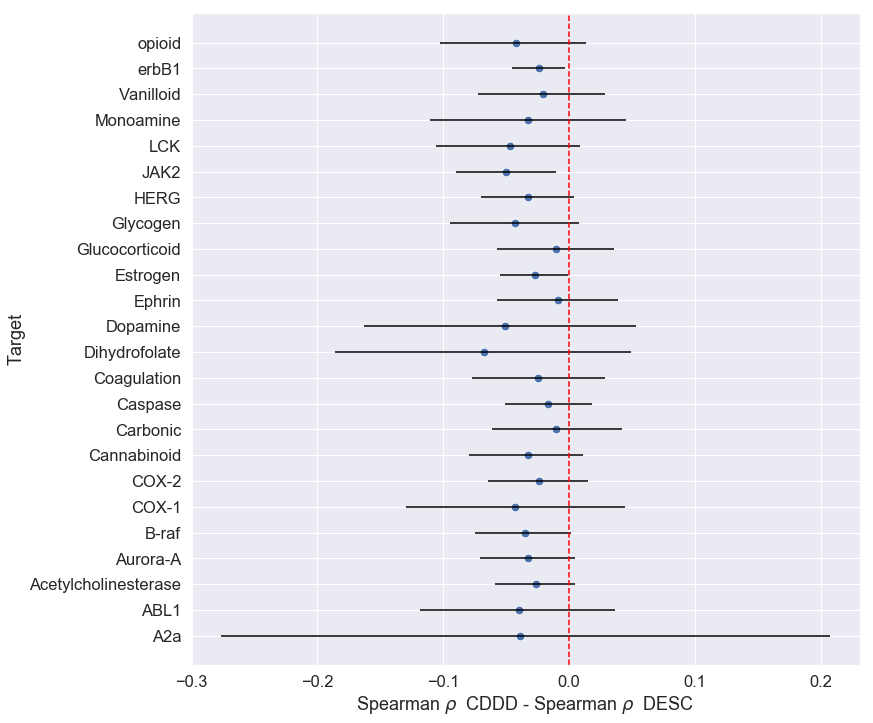

In [15]:
plot_deltas(delta_df,r"Spearman $\rho$  CDDD - Spearman $\rho$  DESC")

In [17]:
delta_df = evaluate_deltas(df,'cddd','desc',kendalltau)

100%|██████████| 240/240 [03:25<00:00,  1.43it/s]

A2a -0.25 -0.04 0.16 0.59
ABL1 -0.11 -0.04 0.03 0.67
Acetylcholinesterase -0.06 -0.02 0.00 0.71
Aurora-A -0.06 -0.03 0.01 0.72
B-raf -0.08 -0.04 -0.00 0.71
COX-1 -0.10 -0.03 0.03 0.58
COX-2 -0.06 -0.02 0.01 0.69
Cannabinoid -0.08 -0.03 0.01 0.74
Carbonic -0.08 -0.02 0.04 0.76
Caspase -0.06 -0.02 0.02 0.73
Coagulation -0.07 -0.02 0.02 0.68
Dihydrofolate -0.16 -0.06 0.03 0.62
Dopamine -0.14 -0.05 0.05 0.66
Ephrin -0.06 -0.01 0.03 0.69
Estrogen -0.06 -0.03 -0.00 0.80
Glucocorticoid -0.05 -0.01 0.03 0.72
Glycogen -0.09 -0.04 0.00 0.67
HERG -0.06 -0.03 0.00 0.61
JAK2 -0.08 -0.05 -0.01 0.70
LCK -0.10 -0.05 0.00 0.69
Monoamine -0.09 -0.03 0.04 0.59
Vanilloid -0.06 -0.02 0.02 0.68
erbB1 -0.05 -0.02 -0.00 0.73
opioid -0.10 -0.04 0.01 0.72


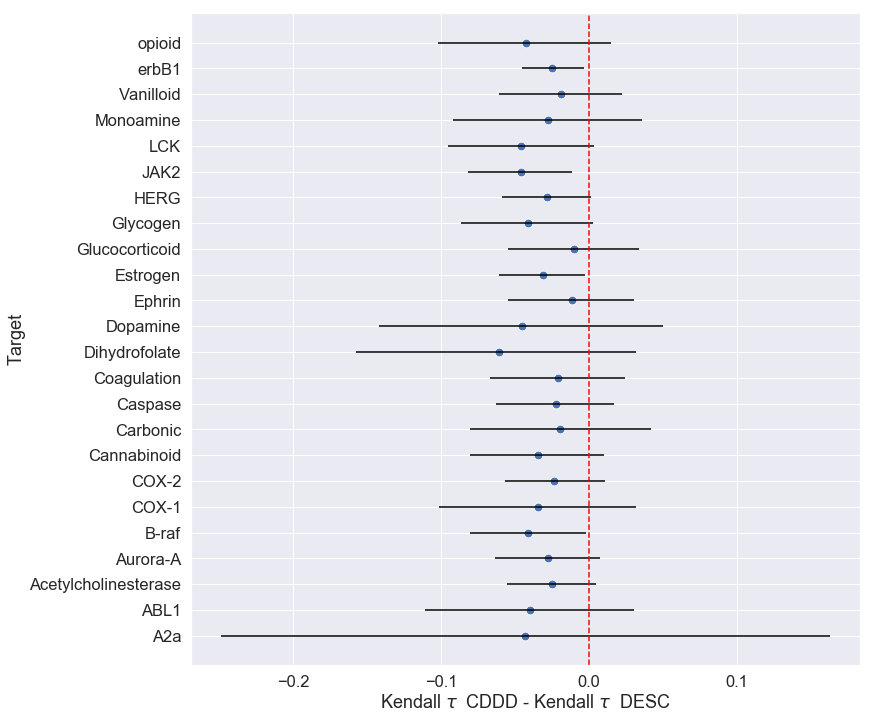

In [18]:
plot_deltas(delta_df,r"Kendall $\tau$  CDDD - Kendall $\tau$  DESC")